# Energy consumption modeling revisited. 

In our [previous report](https://eclever.atlassian.net/wiki/spaces/DEV/pages/2923528193/Modeling+of+energy+consumption+Opel+Mokka) on the modeling of energy consumption from electric vehicles (EV) based on real vehicle data, we took an approach in which we tried to to determine the energy consumption for each and every data point of the drive data. The idea was to calculate the change in energy consumption in between data measurements based on the readings of the state of charge (SoC). The problem, however, was that, depending on the vehicle model the recorded value of SoC had a rather coarse value step. Some EVs, for instance, record the change in SoC each 1%, others each 0.5%, and in the best of cases this step was in the 0.1% order. This results in a dataset where the consumption values could be over or underestimated due to the fact that SoC values have been rounded, so some information is lost in this process, specially for those autos where the reading step is in the 1% range.

This condition forced us to consider different machine learning (ML) models for different vehicles depending on this SoC step. Moreover, in our previous report we came up with a rather complicated model which consisting of an ensemble voting classifier combining a multilayer perceptron, a random forest regressor and a support vector regressor algorithm. This makes the whole search for plausible models very complicated and time consuming.

In this report we aim to simplify the modeling of the energy consumption and make it a unified single model that applied for all EVs. To do this we will based on the approach taken when we modeled the [battery temperature evolution while driving](https://eclever.atlassian.net/wiki/spaces/DEV/pages/3025764353/Battery+temperature+evolution+and+prediction+during+drive+events.). 

The content of this notebook is as follows:

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-description" data-toc-modified-id="Data-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data description</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#Outliers-and-missing-data" data-toc-modified-id="Outliers-and-missing-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Outliers and missing data</a></span></li><li><span><a href="#Wrong-SoC-values" data-toc-modified-id="Wrong-SoC-values-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Wrong SoC values</a></span></li><li><span><a href="#Other-preprocessing:" data-toc-modified-id="Other-preprocessing:-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Other preprocessing:</a></span></li></ul></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model selection</a></span><ul class="toc-item"><li><span><a href="#Final-model" data-toc-modified-id="Final-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Final model</a></span></li><li><span><a href="#Consumption-curves" data-toc-modified-id="Consumption-curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Consumption curves</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import importlib.util
import sys
path = '/home/jehamann/eClever/repositories/battery-temp-trainer/src/'
sys.path.append(path)

spec = importlib.util.spec_from_file_location("config", path+"config.py")
module = importlib.util.module_from_spec(spec)
sys.modules['config'] = module
spec.loader.exec_module(module)

# from IPython.display import display, Markdown, Latex
import pandas as pd
from config import get_config
from helpers import DatabaseHelper, DataHandlerHelper
import matplotlib.pyplot as plt
import seaborn as sns

with DatabaseHelper.connect_mongodb() as mongo_conn:
    data = DatabaseHelper.query_data(mongo_conn, anonymous=False)

## Data description

The data used for developing of this model is exactly the same as that use for the battery temperature porject. The difference however is that we are not ineterasted on the final battery temperature at the drive event, but on the final SoC value. The table below shows a short example of the data that will be used in this work. In the table each row contains information of a single drive event. For each drive we have collected the following information:

- timestamp: Date time of the beginning of the drive.
- altitude_i: Altitude at the start location.
- delta_altitude: Altitude difference between the final and starting point of the drive in meters.
- total_distance: Total distance of the drive in km.
- total_time: Total duration of the drive in hours.
- air_temp: Air temperature at the beginning of the drive in °C.
- soc_i: SoC of the battery at the beginning of the drive in %.
- soc_f: SoC of the battery at the end of the drive in %.
- battery_temp_i: Battery temperature at the beginning of the drive in °C.
- battery_temp_f: Battery temperature at the end of the drive in °C.
- odometer: Total amount of kms driven by the car.
- vehiclevariant_id: eClever vehiclevariant identifier.
- consumptioncurvegroup_id: eClever consumption curve group identifier.

For the purpose of modeling the energy consumption, we are basically interested in the initial conditions of the drive, hence, the *battery_temp_f* will not be considered.

The target value to predict will be the *soc_f*, whereas the other parameters will be used as feature values for the learning model.

In [2]:
data.head()

timestamp  altitude_i  delta_altitude  total_distance  total_time  \
0 2021-07-14 10:28:20       321.0             -35             3.3    0.140556   
1 2021-07-14 10:48:49       301.0              77            11.6    0.226111   
2 2021-07-15 07:19:00       534.0            -248            85.1    0.795000   
3 2021-07-15 08:12:19       291.0             160           119.2    1.217222   
4 2021-07-15 10:37:25       452.0             114           175.1    1.931944   

   air_temp  soc_i  soc_f  battery_temp_i  battery_temp_f  odometer  \
0      17.0  100.0  100.0            20.0            20.0     352.0   
1      18.0  100.0   96.5            20.0            20.0     356.0   
2      16.0   82.5   59.5            22.0            26.0     435.0   
3      18.0   59.5   23.5            26.0            31.0     521.0   
4      18.0  100.0   53.5            31.0            30.0     640.0   

   vehiclevariant_id  consumptioncurve_id  
0              599.0                 69.0  
1              599.0                 69.0  
2              599.0                 69.0  
3              599.0                 69.0  
4              599.0                 69.0

## Data preprocessing

### Outliers and missing data

The procedure of data cleaning and imputation of missing data is done exactly the same way as with the battery temperature project. This is, we get rid of outliers by considering only data that is withing 4 standard deviations from the mean value. The Missing air temperature values are filled, whit help of time data where we determine which was the mean air temperature at a given calendar week and use this as the filling value.

### Wrong SoC values

Wrong SoC values are filtered out by taking only values where 0 $\lt$ *soc_i* $\le$ 100 and *soc_f* $lt$ 100.


### Other preprocessing:

Additional to the above discussed data preprocessing steps, we have also done some rounding of values for the temperatures and SoC.

Also, we have added the *speed_av* column which corresponds to the average speed through all the drive. This is determined based on traveled distance and the total time it took to finished the drive.

Finally, we remove duplicate data.

In [40]:
def data_preprocessing(df, plot=False):

    dff = df.copy()
    
    # drop entries with no vehiclevariant_id
    dff = dff.dropna(subset=['vehiclevariant_id'])

    # imput missing odometer values with mean value
    dff["odometer"] = dff["odometer"].fillna(value=dff['odometer'].mean())

    # inpute missing air temp values with mean data of calender week
    dff = add_time_features(dff)
    
    temp_dict = dff[["week", "air_temp"]].groupby("week").mean().interpolate().round().to_dict()["air_temp"]
    null_idx = dff[dff["air_temp"].isnull()].index
    dff.loc[null_idx, "air_temp"] = dff.loc[null_idx, "week"].apply(lambda x: temp_dict[x]).values

    # remove wrong SoC values 
    dff = dff.query("soc_i < 100 and soc_i > 0")
    dff = dff.query("soc_f <= 100")

    # add speed from distance and time
    dff["speed_av"] = round(dff["total_distance"] / dff["total_time"])
    
    # remove outliers
    rm_outliers_list = [
        "speed_av",
        "altitude_i",
        "total_distance",
        "delta_altitude",
        "battery_temp_i",
        "battery_temp_f",
        "air_temp",
    ]

    dff = DataHandlerHelper.remove_outliers(dff, rm_outliers_list)

    # round values
    cols_to_round = ["soc_i", "battery_temp_i", "battery_temp_f", "air_temp"]
    dff = DataHandlerHelper.round_cols(dff, cols_to_round)

    # drop duplicate data
    dff = dff.drop_duplicates()

    return dff

def add_time_features(df):
    df["month"] = df["timestamp"].apply(lambda x: x.month)
    df["week"] = df["timestamp"].apply(lambda x: x.week)
    return df

data_cleaned = data_preprocessing(data)

data_cleaned.describe()

altitude_i  delta_altitude  total_distance    total_time  \
count  50971.000000    50971.000000    50971.000000  50971.000000   
mean     247.684997        1.301740       19.689212      0.357879   
std      183.054784       65.555944       26.531219      0.320149   
min     -244.000000     -332.000000        0.000000      0.028889   
25%      103.000000      -21.000000        4.600000      0.145278   
50%      176.000000        1.000000        9.500000      0.250278   
75%      354.000000       24.000000       22.100000      0.452222   
max     1072.000000      338.000000      162.100000      2.860278   

           air_temp         soc_i         soc_f  battery_temp_i  \
count  50971.000000  50971.000000  50971.000000    50971.000000   
mean      12.623198     68.039572     60.540641       16.619843   
std        7.888744     22.083241     23.354808        8.480578   
min      -14.000000      0.000000      0.000000      -30.000000   
25%        6.000000     52.000000     43.000000       10.000000   
50%       12.000000     72.000000     63.400000       16.000000   
75%       19.000000     86.000000     80.000000       22.000000   
max       41.000000    100.000000    100.000000       62.000000   

       battery_temp_f       odometer  vehiclevariant_id  consumptioncurve_id  \
count    50971.000000   50971.000000       50971.000000         50971.000000   
mean        17.368013   16029.670524         472.567852            43.847953   
std          8.059041   17480.515620          86.137554            22.702783   
min         -4.000000      10.000000         327.000000             2.000000   
25%         11.000000    5467.500000         415.000000            24.000000   
50%         17.000000   10474.000000         446.000000            49.000000   
75%         23.000000   19013.500000         585.000000            66.000000   
max         50.000000  117168.000000         607.000000            69.000000   

              month          week      speed_av  
count  50971.000000  50971.000000  50971.000000  
mean       7.445371     30.374566     45.634439  
std        3.477980     15.058807     22.501720  
min        1.000000      1.000000      0.000000  
25%        5.000000     21.000000     28.000000  
50%        8.000000     34.000000     41.000000  
75%       10.000000     42.000000     58.000000  
max       12.000000     52.000000    159.000000

The table above shows again the descriptive statistics of the data after pre-processing. As we can see there is no missing values, all columns have the same count value of 50971. Which means that we are using this amount of drives to train our model.

Let us now have a look at the data as histograms to have a better data visualization.

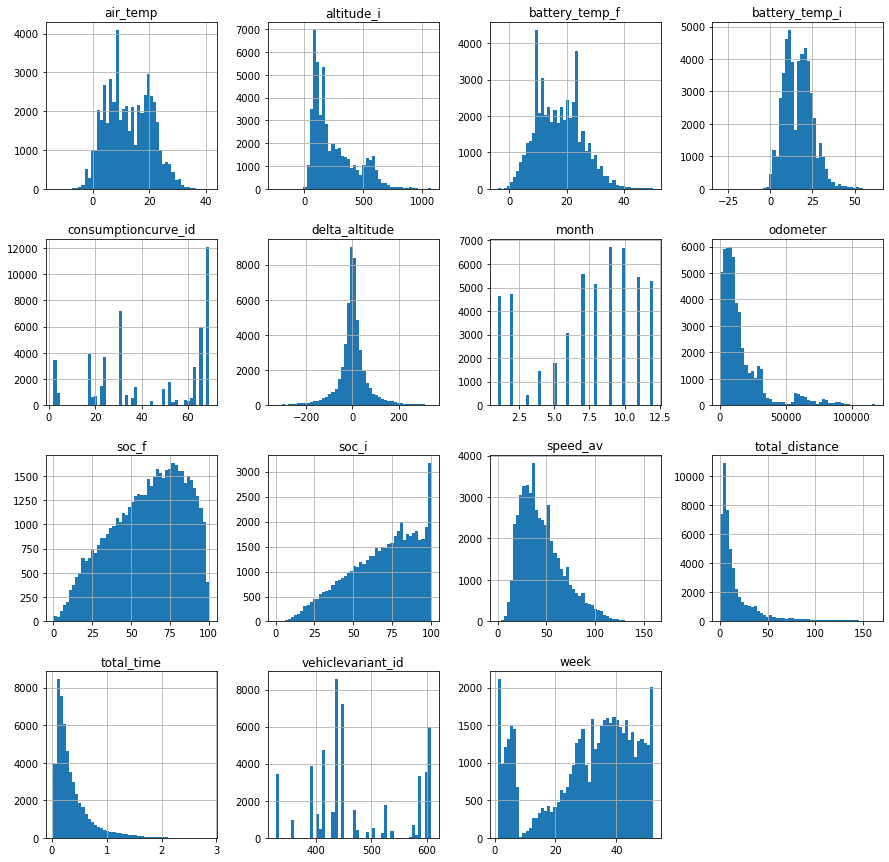

In [41]:
data_cleaned.hist(bins=50, figsize=(15,15));

Let us now jump into the next step which is the machine model selection.

## Model selection

Following the same strategy as from the previous projects, the model selection is done by first splitting the data in a train (80%) and a validation set (20%). With the train set we will try many different regression algorithms with different standardizing/normalization procedures. These models will be trained using a 3-fold cross validation. 

Also, categorical features like *vehiclevariant_id* and *consumptioncurvegroup_id* will be encoded as one hot numeric arrays. We use one hot encoding because these ids are not ordinal, this is, there is no hierarchy or natural order that defines them. So to avoid that the model tries to assume a non existing ordering among the labels we use one hot encoding.

The scoring metrics that we will use to judge the model performance are the mean absolute error (MAE), the root mean squared error (RMSE) and the coefficient of regression ($r^2$). Remember that for MAE and RMSE, the lowest these values are, the better. Whereas for $r^2$ the closest it gets to 1 the better.

In [13]:
from sklearn.model_selection import (RandomizedSearchCV, train_test_split,
                                     StratifiedKFold, cross_val_score)
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (
    SGDRegressor, Lars, LassoLars, OrthogonalMatchingPursuit, 
    ARDRegression, HuberRegressor, TheilSenRegressor, BayesianRidge,
    LinearRegression, Lasso, ElasticNet, Ridge)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from datetime import datetime
import seaborn as sns
import numpy as np
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

one_hot_encoder = OneHotEncoder(sparse=False)
def setup_models_one_hot(cat_cols, scaler=None):
    """
    creates a dict with different models to train.
    
    scaler (str): type of scaler to use to pre-process the data. 
    """
    scaler_dict = {
        "power_scaler": PowerTransformer(),
        "standard_scaler": StandardScaler(),
        "quantile_transform": QuantileTransformer(
            output_distribution='normal', random_state=42)
    }
    # algorithms to try
    model_list=[
        BayesianRidge(),
        AdaBoostRegressor(),
        SGDRegressor(random_state=42),
        LinearRegression(),
        KNeighborsRegressor(n_jobs=-1),
        MLPRegressor(random_state=42),
        SVR(),
        ARDRegression(),
        Lasso(),        
        HuberRegressor(),
        ElasticNet(),
    ]
    
    col_trans = ColumnTransformer(
    transformers=[
        ("one_hot_vehicleid",one_hot_encoder, cat_cols),
        ],
    remainder=scaler,
    )
    
    if scaler:
        model_dict = {type(model).__name__: make_pipeline(
            ColumnTransformer(
                transformers=[
                    ("one_hot_vehicleid", one_hot_encoder, cat_cols),
                    ],
                remainder=scaler_dict[scaler],
                ),
            model) for model in model_list}
    else:
        model_dict = {type(model).__name__: make_pipeline(
            ColumnTransformer(
                transformers=[
                    ("one_hot_vehicleid", one_hot_encoder, cat_cols),
                    ],
                remainder="passthrough",
                ),
            model) for model in model_list}

    return model_dict

def do_train_test_split(df, feature_cols, target_cols, stratify=None):
    """
    Creates train and test datasets.
    
    df (DataFrame): Original data
    feature_cols (list): list with names of cols in df to be used as features
    target_cols (list): list with names of cols in df to be used as target
    stratify (str): name of column use to do stratified train-test splitting
    """
    # set features and targets
    features = df[feature_cols]
    targets = df[target_cols]

    if stratify:
        stratify = df[stratify]

    return train_test_split(
        features, targets,
        stratify= stratify,
        test_size=0.2, random_state=42)

def evaluate_model(model, features, targets):
    """
    Evaluates a model and determines mae, mse and r2 metrics
    
    model (object): ML model to score
    features (DataFrame): data with features to predict
    targets (DataFrame): actual values 
    """
    predictions = model.predict(features)
    mae = mean_absolute_error(targets, predictions)
    mse = mean_squared_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return pd.DataFrame({"MAE":mae, 
                         "RMSE":np.sqrt(mse),
                         r"$r^2$": r2}, index=[0]).round(3)

def compare_model_scores_cv(models, X, y, stratify, score=None):
    """
    This function compares predictive scores from different ML algorithms
    """
    if score:
        scorer = make_scorer(score)
    else:
        scorer = "r2"

    scores = [{"model": model,
               "cv_score": cross_val_score(
                   models[model], X, y.values.ravel(), cv=skf.split(X, X[stratify]), n_jobs=-1, scoring=scorer).mean(),
             } for model in models]

    return (
        pd.DataFrame(scores)
        .set_index("model")
        .sort_values(by="cv_score")
        .round(3)
           )

def model_selector1(df, feature_cols, target_cols, cat_cols, stratify):
    tree_based_model_list=[
        GradientBoostingRegressor(random_state=42),
        RandomForestRegressor(random_state=42, n_jobs=-1),
        ExtraTreesRegressor(random_state=42, n_jobs=-1)
    ]
    
    cv_results = pd.DataFrame()
    val_results = pd.DataFrame()
    scalers = [None, "power_scaler", "standard_scaler", "quantile_transform"]
    X_train, X_test, y_train, y_test = do_train_test_split(
        df, feature_cols, target_cols, stratify)
    for scaler in scalers:
        models = setup_models_one_hot(cat_cols, scaler=scaler)
        # add tree based models
        if scaler == None:
            for model in tree_based_model_list:
                    models[type(model).__name__] = make_pipeline(
                        ColumnTransformer(
                            transformers=[
                                ("one_hot_vehicleid", one_hot_encoder, cat_cols),
                                ],
                            remainder="passthrough",
                            ),
                        model
                        ) 

        cv_scores = compare_model_scores_cv(models, X_train, y_train, stratify, score=mean_squared_error)
        cv_scores["scaler"] = scaler
        cv_results = pd.concat([cv_results, cv_scores])
        for model in models:
            base_model = models[model].fit(X_train, y_train.values.ravel())
            val_scores = evaluate_model(base_model, X_test, y_test).round(4)
            val_scores["model"] = model
            val_scores["scaler"] = scaler
            val_results = pd.concat([val_results, val_scores])

    joined_res = pd.merge(
        cv_results, val_results,  how='left', left_on=['model','scaler'], right_on = ['model','scaler']).sort_values(by="RMSE")
    joined_res["cv_score"] = np.sqrt(joined_res.cv_score)
                
    return joined_res.set_index("model")

def model_selector(df, feature_cols, target_cols, cat_cols, stratify):
    results = pd.DataFrame()
    scalers = [None, "power_scaler", "standard_scaler", "quantile_transform"]
    X_train, X_test, y_train, y_test = do_train_test_split(
        df, feature_cols, target_cols, stratify)
    for scaler in scalers:
        models = setup_models_one_hot(cat_cols, scaler=scaler)
        for model in models:
            base_model = models[model].fit(X_train, y_train)
            scores = evaluate_model(base_model, X_test, y_test).round(4)
            scores["model"] = model
            scores["scaler"] = scaler
            results = pd.concat([results, scores])
    return results.sort_values(by="RMSE")

In this work again, as a first approach we will use only one of the categorical features starting with the *consumptioncurvegroup_id*. Then we will use the *vehiclevariant_id* and see if there is an advantage on using one against the other.

In [15]:
warnings.filterwarnings("ignore")
# initial data
target_cols = [
    'soc_f'    
]

feature_cols = [
#     'timestamp',
    "altitude_i",
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
#     'vehiclevariant_id',
    'consumptioncurve_id',
]

cat_cols = [
#    "vehiclevariant_id",
    "consumptioncurve_id",
]
selector_res_ccid  = model_selector1(
    data_cleaned, feature_cols, target_cols, cat_cols, "consumptioncurve_id")

text = "Table 1. Algorithm scores - Consumption curve ID"
print(text, "\n"+"_"*len(text))
selector_res_ccid.sort_values(by="RMSE").head(10)

Table 1. Algorithm scores - Consumption curve ID 
________________________________________________


cv_score              scaler    MAE   RMSE  $r^2$
model                                                                       
MLPRegressor               2.578372     standard_scaler  1.243  2.737  0.987
MLPRegressor               2.600769        power_scaler  1.254  2.762  0.987
MLPRegressor               2.701481  quantile_transform  1.278  2.827  0.986
MLPRegressor               2.749364                None  1.655  3.078  0.984
ExtraTreesRegressor        3.041874                None  1.467  3.101  0.983
RandomForestRegressor      3.337214                None  1.640  3.376  0.980
GradientBoostingRegressor  3.394849                None  1.785  3.520  0.978
SVR                        3.673554     standard_scaler  1.587  3.631  0.977
SVR                        3.780212  quantile_transform  1.678  3.777  0.975
LinearRegression           3.808543                None  2.155  4.004  0.972

The table above shows the top ten models with the best performance. This was judge based on the value of the root mean squared error (RMSE) based on the validation dataset. The table also shows the cv_score, which is the resulting RMSE score after the 3 fold cross validation. The mean absolute error (MAE) and the coefficient of determination ($r^2$)

From the table we can see that the best model is a multilayer perceptron regressor (MLPRregressor) using a standard scaler as normalization. For this model the $r^2$ has a value of 0.987, which is really good. Remember that the best possible value is 1. Also, we see that the mean absolute error (MAE) is about 1.2 % of SoC. Meaning that for the routes of the evaluation set (about 10000 drives) the mean absolute error between predicted final SoC and the real values is 1.2% of SoC. 

Now, lets try to see if by including the *vehiclevariant_id* instead of the *consumptioncurvegroup_id* yields better performance.

In [42]:
warnings.filterwarnings("ignore", message="ConvergenceWarning")
# initial data
target_cols = [
    'soc_f'    
]

feature_cols = [
#     'timestamp',
    "altitude_i",
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
    "vehiclevariant_id",
#    "consumptioncurve_id",
]
selector_res_vvid = model_selector1(
    data_cleaned, feature_cols, target_cols, cat_cols, "vehiclevariant_id")

text = "Table 2. Algorithm scores - Vehicle variant ID"
print(text, "\n"+"_"*len(text))
selector_res_vvid.sort_values(by="RMSE").head(10)

Table 2. Algorithm scores - Vehicle variant ID 
______________________________________________


cv_score              scaler    MAE   RMSE  $r^2$
model                                                                       
MLPRegressor               2.406242     standard_scaler  1.191  2.410  0.989
MLPRegressor               2.447243        power_scaler  1.183  2.429  0.989
MLPRegressor               2.547155  quantile_transform  1.243  2.514  0.988
MLPRegressor               2.596921                None  1.661  2.809  0.985
ExtraTreesRegressor        2.898275                None  1.420  2.833  0.985
RandomForestRegressor      3.197186                None  1.598  3.080  0.982
GradientBoostingRegressor  3.274294                None  1.731  3.238  0.981
SVR                        3.552323     standard_scaler  1.538  3.290  0.980
SVR                        3.780079  quantile_transform  1.648  3.444  0.978
SGDRegressor               3.635932     standard_scaler  2.065  3.634  0.976

In the table above, we see again the top ten models scores. Here again the MLPregressor with a standar scaler has the best $r^2$ score and a rather low MAE. However we see that using *vehiclevariant_id* has slightly better score values, 0.989 with respect to 0.987 as the *consumptioncurvegroup_id*. Also the MAE is slightly better. Therefore, we will stick with the *vehiclevariant_id* as feature and continue with our next step which is the hyperparameter tunning and final model determination.

Here again, as in the previous battery temperature project, we have tried using the odometer, month and calender week to see if the regression performance increases, but this was not the case.

To finish this section we can also plot the residuals between the predicted and real values of the final target (final battery temperature) in order to have a visual understanding on how good the predictions are.

In [214]:
def plot_residuals(model, x, y, hue):
    """
    Plots the residuals after prediction
    
    model (object): ML model
    x (DataFrame): data with features to predict
    y (DataFrame): actual values 
    """
    df = x.copy()
    predicted = model.predict(x)
    df["predicted"] = predicted
    df["real"] = y
    df["diff"] = y-predicted
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    palette = "bright"
    sns.regplot(predicted, y, ax=ax, scatter_kws={'alpha':0.3})
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    ax = fig.add_subplot(1, 2, 2)
    sns.residplot("predicted", "real", data=df,ax=ax, scatter_kws={'alpha':0.3})
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.grid(True, axis="y")
    fig.tight_layout()   

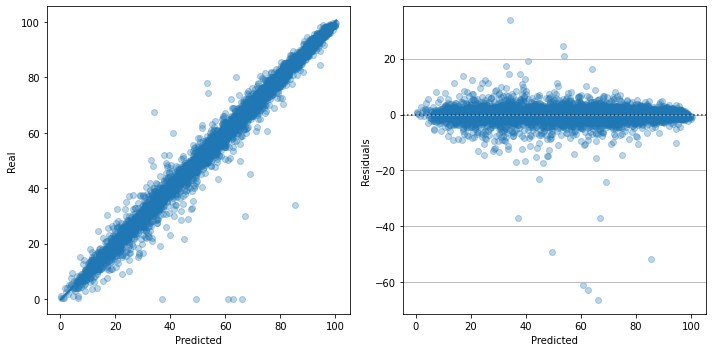

In [64]:
best_model = setup_models_one_hot(cat_cols, scaler="standard_scaler")["MLPRegressor"]

X_train, X_test, y_train, y_test = do_train_test_split(
        data_cleaned, feature_cols, target_cols, "vehiclevariant_id")

best_model.fit(X_train, y_train.values.ravel())

plt.rc('font', size=10)
plot_residuals(best_model, X_test, y_test.values.reshape(-1), hue=None);

The figure above shows the predicted values vs. the real values (left) together with the residuals plot (right). As we can see in the residuals plot, the data clusters around the zero line. By having a look at the statistics of the residuals we can actually say that about 5% of the predicted data has an error grater than 3.5% of SoC which is pretty good. 

In [310]:
test=pd.DataFrame({
    "real": y_test.values.reshape(-1),
    "predicted": best_model.predict(X_test)
})
test["error"] = abs(test.real-test.predicted)
# test.hist(figsize=(10,10), bins=50);
print(f"Error 0.95 percentile: {abs(test.error).quantile(0.95):.2f}%")
test[["error"]].describe().round(2)

Error 0.95 percentile: 3.76%


error
count  10195.00
mean       1.19
std        2.09
min        0.00
25%        0.32
50%        0.71
75%        1.37
max       66.20

### Final model

The hyperparameter tunning was done as we have been doing in previous projects, where we perform an Random Grid Search with k-fold cross validation. So we first search the best parameters on a large hyperparameter grid space. Then we identify regions in this space where the scorings are being improved and repeat the procedure on a smaller space until we find the best combination of parameters possible.

The whole procedure will not be shown here, we will only show the final result which is the following:

+ Estimator: MLPRregressor
+ hidden_layer_sizes: 400 
+ max_iter: 900
+ beta_1: 0.5
+ beta_2: 0.6
+ activation: "logistic"
+ random_state: 42

This model gives us a slightly better performance.

Table . MLP. metrics before and after fine tuning.


MAE   RMSE  $r^2$
Optimization                     
before        1.191  2.410  0.989
after         1.149  2.386  0.989

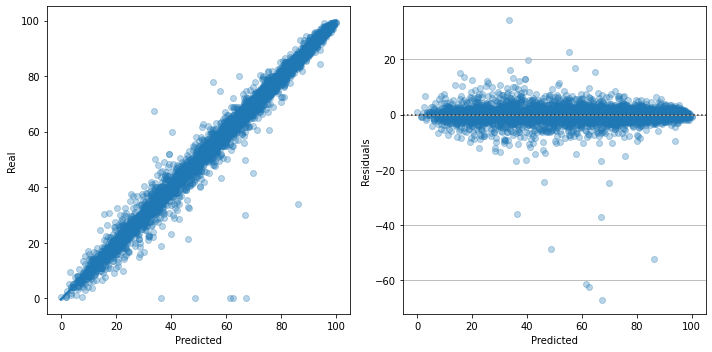

In [311]:
warnings.filterwarnings("ignore", message="ConvergenceWarning")
# initial data
target_cols = [
    'soc_f'    
]

feature_cols = [
#     'timestamp',
    "altitude_i",
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
    "vehiclevariant_id",
#    "consumptioncurve_id",
]

X_train, X_test, y_train, y_test = do_train_test_split(
        data_cleaned, feature_cols, target_cols, "vehiclevariant_id")

#final optimized regressor
estimator = MLPRegressor(
    hidden_layer_sizes=400, 
    max_iter=900,
    beta_1=0.5,
    beta_2=0.6,
    activation="logistic",
    random_state=42,
    )

col_trans = ColumnTransformer(
    transformers=[
        ("vehicleid",OneHotEncoder(sparse=False), cat_cols),
        ],
        remainder=StandardScaler(),
    )

mlp_hp_best = make_pipeline(
    col_trans,
    estimator
    )

mlp_hp_best.fit(X_train, y_train.values.ravel())

base_model = setup_models_one_hot(
    cat_cols, scaler="standard_scaler")["MLPRegressor"]
base_model.fit(X_train, y_train)

mlp_before = evaluate_model(base_model, X_test, y_test)
mlp_before["Optimization"] = "before"

mlp_after = evaluate_model(mlp_hp_best, X_test, y_test)
mlp_after["Optimization"] = "after"

plt.rc('font', size=10)
plot_residuals(mlp_hp_best, X_test, y_test.values.reshape(-1), hue=None);

print("Table . MLP. metrics before and after fine tuning.")
pd.concat([mlp_before, mlp_after]).set_index("Optimization")

The table above shows the scores of the model before and after hyperparameter tunning. We see, that after tunning, there is a slight increase in prediction performance of the model. For completeness we also show above a figure with the residuals plot of the model after tunning. 

To finalize, let us now, plot some real energy consumptions from real drive data, together with the corresponding predictions based on the model here described. 

In [465]:
def get_trip_data():
    with DatabaseHelper.connect_mongodb() as mongo_conn:
        query = [
            {
                "$match": {
                    "driveInfo.totalDriveDistance": {
                        "$gt": 60
                    },
                    "driveProfile.airTemp": {
                        "$ne": None
                    }
                },
            },
            {
                "$sample": {"size": 10},
            },
            {
                "$project": {
                    "timestamp": "$driveInfo.startTime",
                    "soc": "$driveProfile.soc",
                    "altitude": "$driveProfile.altitude",
                    "distance": "$driveProfile.distance",
                    "speed": "$driveProfile.speed",
                    "battery_temp": "$driveProfile.batteryTemp",
                    "air_temp": "$driveProfile.airTemp",
                    "time": { 
                        "$divide": [
                            {"$subtract": [
                                "$driveInfo.endTime","$driveInfo.startTime"
                                ]},
                            3600000,
                            ],
                    },
                    "vehiclevariant_id": "$vehicleVariantId",  
                    "consumptioncurve_id": "$consumptionCurveGroupId",  
                    "_id": 0,
                },
            },
        ]

        collection = mongo_conn[get_config().MONGODB_DB][get_config().MONGODB_COLLECTION_DRIVES]
        data_df = list(collection.aggregate(query))
        data_df = [pd.DataFrame(drive) for drive in data_df]

        DatabaseHelper.logger.debug(
            "DatabaseHelper - query_data() - "
            "{} Entries found.".format(len(data_df))
        )
        return data_df


def plot_check_with_real(drive, ax, model):
    test_df = pd.DataFrame({
        'altitude':drive.altitude,
        'speed':drive.speed,
        'distance': drive.distance,
        'air_temp':drive.air_temp.round(),
        'soc':drive.soc.round(),
        'time':drive.time,
        'battery_temp':drive.battery_temp.round(),
        "vehiclevariant_id": drive.vehiclevariant_id,
    })
    # ML features for each point in drive
    test_df['altitude_i'] = test_df.altitude
    test_df['delta_altitude'] = test_df.altitude.diff().shift(-1)
    test_df['speed_av'] = round(test_df.distance.iloc[-1] / test_df.time.iloc[0])
    test_df['total_distance']=test_df.distance.diff().shift(-1)
    test_df['air_temp'] = test_df.air_temp
    test_df['soc_i'] = test_df.soc
    test_df['soc_f'] = test_df.soc.shift(-1)
    test_df['battery_temp_i'] = test_df.battery_temp
    test_df = test_df.dropna()
    test_df["predicted"] = model.predict(test_df[feature_cols]).round()

    # ML features for the whole drive
    full_trip = pd.DataFrame({
        "altitude_i": test_df.altitude.iloc[0],
        'delta_altitude': test_df.altitude.iloc[-1] - test_df.altitude.iloc[0],
        "speed_av": round(test_df.distance.iloc[-1] / (test_df.time.iloc[-1])),
        "total_distance": test_df.distance.iloc[-1].round(),
        "air_temp": test_df.air_temp.iloc[0],
        "soc_i": test_df.soc.iloc[0],
        "battery_temp_i": test_df.battery_temp.iloc[0],
        "vehiclevariant_id": test_df.vehiclevariant_id.iloc[0]
    }, index=[0])

    full_trip["predicted"] = model.predict(full_trip[feature_cols]).round()
    
    sns.lineplot(data=test_df, x="distance", y="soc_f",  marker='o', label="real", ax=ax);
    sns.lineplot(data=test_df, x="distance", y="predicted",  marker='o', label="predicted", ax=ax);
    ax.errorbar(full_trip.total_distance, full_trip.predicted, yerr=2, marker="o", ms=10, c="green", label=f"pred. full route: {full_trip.predicted[0]}%");
    ax.set_title("VariantId: {}\nFinal SoC: {}%, MAE: {:.2f}%".format(
        test_df.vehiclevariant_id.iloc[0],
        test_df.soc.iloc[-1],
        mean_absolute_error(test_df.predicted, test_df.soc_f)));

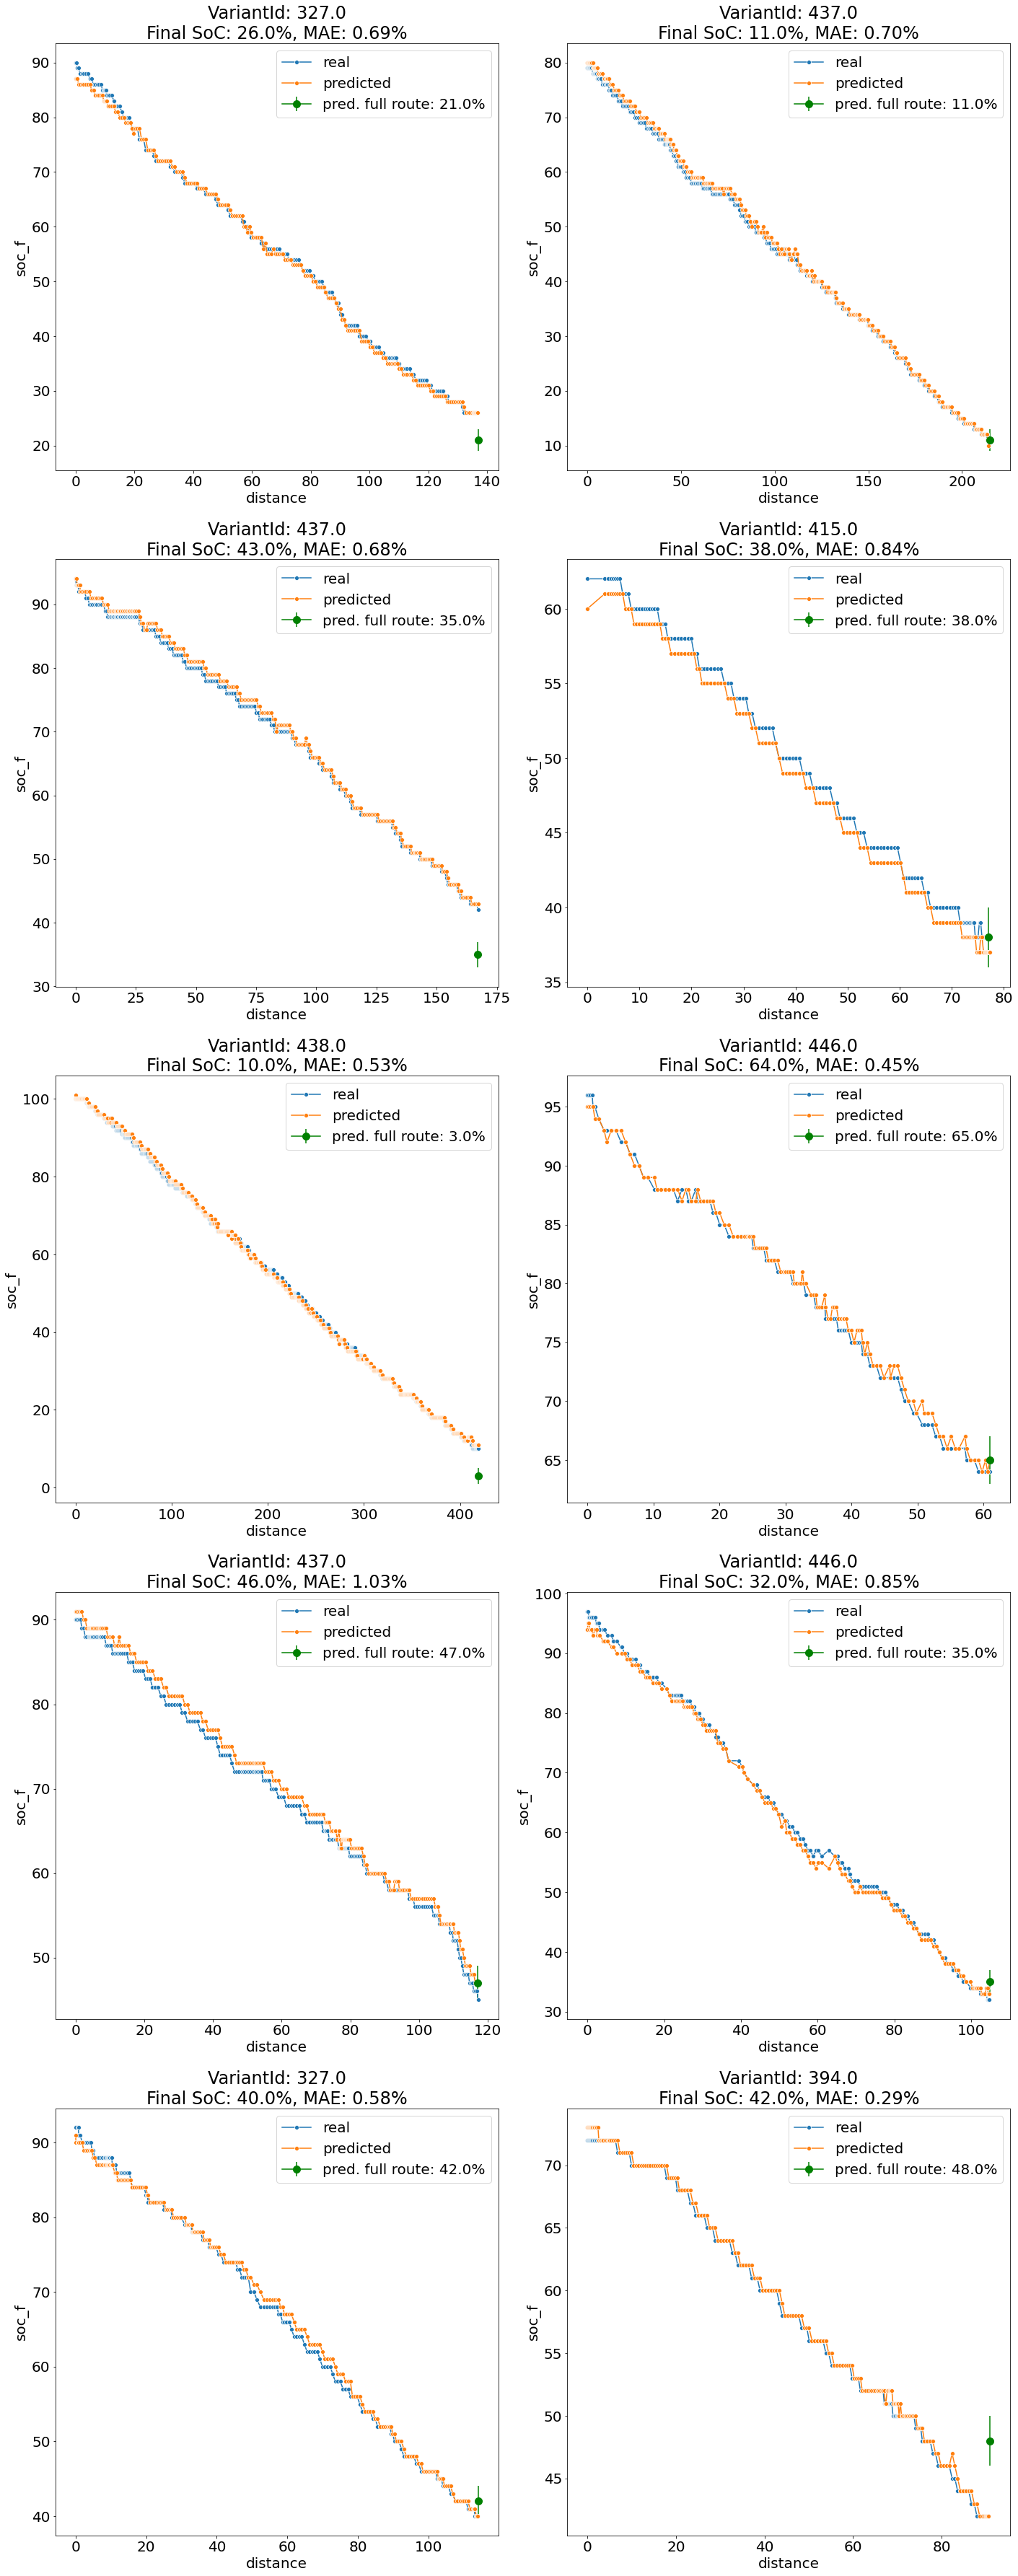

In [415]:
drives = get_trip_data()

fig = plt.figure(figsize=(20,50));
plt.rc('font', size=20);
for i, drive in enumerate(drives):
    ax = fig.add_subplot(5,2,i+1);
    plot_check_with_real(drive, ax, mlp_hp_best);
    ax.legend()
    plt.tight_layout();

The Figure above shows the SoC vs. traveled distance in km for randomly selected drives. The blue data shows the real data, whereas the orange one corresponds to the predicted values. On top of each figure it is also depicted the corresponding MAE and the *vehiclevariant_id*. As observed the predictions match pretty nicely the real data, we see also that for each drive, the MAE is mostly around or lower than 1%. The green point shows the prediction when one only considers the initial conditions of the route.

### Consumption curves

With the ML model that we have, we are now able to plot consumption curves. For that we have to make some assumptions, for istance, we will assume that the initial altitude is 100m and that the change in altitude is zero. With this we can define some temperature dependent curves. As the ones show below.

In [452]:
vvid_dict = {
    327: {"battery": 64, "name": "e-tron 50, AC single 22 kW"},
    356:  {"battery": 37, "name": "i3 (120 Ah)"},
    391:  {"battery": 28, "name": "IONIQ Elektro 31 kWh"},
    392:  {"battery": 38, "name": "IONIQ Elektro 42 kWh"},
    394:  {"battery": 64, "name": "KONA Elektro 67 kWh, AC 7,2 kW"},
    401:  {"battery": 72, "name": "IONIQ 5, 78 kWh, RWD"},
    402:  {"battery": 72, "name": "IONIQ 5, 78 kWh, AWD"},
    409:  {"battery": 39, "name": "e-Soul 136, AC 11 kW"},
    411:  {"battery": 64, "name": "e-Soul 204, AC 11 kW"},
    415:  {"battery": 64, "name": "e-Niro 67 kWh, AC 11 kW"},
    431:  {"battery": 21, "name": "Twingo Electric"},
    432:  {"battery": 36, "name": "Leaf ZE1, 40 kWh, AC 3,6 kW"},
    437:  {"battery": 58, "name": "ID.3 Pro"},
    438:  {"battery": 77, "name": "ID.3 Pro S"},
    446:  {"battery": 28, "name": "Cooper SE"},
    470:  {"battery": 60, "name": "Ampera-e"},
    472:  {"battery": 45, "name": "Corsa-e, 11 kW"},
    473:  {"battery": 45, "name": "Mokka-e, 7,2 kW"},
    490:  {"battery": 72, "name": "Polestar 2, 78 kWh, AWD"},
    503:  {"battery": 41, "name": "ZOE Phase 1, 45 kWh, AC 22 kW"},
    519:  {"battery": 32, "name": "Citigo e iV, ohne CCS"},
    524:  {"battery": 77, "name": "Enyaq iV 80, DC 50 kW"},
    539:  {"battery": 15, "name": "EQ fortwo coupé, AC 22 kW"},
    569:  {"battery": 67, "name": "Model S, 75 kWh, AC 16 kW, AWD"},
    574:  {"battery": 90, "name": "Model S, 100 kWh, AC 11 kW, AWD"},
    578:  {"battery": 67, "name": "Model X, 75 kWh, AC 11 kW"},
    584:  {"battery": 58, "name": "Model 3, 68 kWh, RWD"},
    585:  {"battery": 75, "name": "Model 3, 80 kWh, AWD"},
    586:  {"battery": 75, "name": "Model Y, 80 kWh, AWD"},
    599:  {"battery": 77, "name": "ID.4 Pro"},
    607:  {"battery": 32, "name": "e-up!, 36 kWh"},
}
def get_consumption_curve(model, vvid, t_a, t_b, soc_i):
    battery = vvid_dict[vvid]["battery"]
    speed = list(range(1,121))
    df = pd.DataFrame({"altitude_i":[ 100 for _ in speed]}) 
    df["delta_altitude"] = 0
    df["speed_av"] = speed
    df["total_distance"] = 100
    df["air_temp"] = t_a
    df["soc_i"] = soc_i
    df["battery_temp_i"] = t_b
    df["vehiclevariant_id"] = vvid
    df["soc_f"] = model.predict(df)
    df["consumption"] = battery*(soc_i-df.soc_f)/100
    df["drive_range"] = (df.soc_i)*battery/df.consumption
    return df

def plot_consumption_range(model, vvid, t_b, t_a, soc):
    vehicle_name = vvid_dict[vvid]["name"]
    df = get_consumption_curve(model, vvid, t_b, t_a, soc)
    fig, ax = plt.subplots(2, 1, figsize=(10, 10 ), tight_layout=True)
    plt.suptitle(f"Vehicle: {vehicle_name}\n $T_{{Batt}}: {t_b}$°C, $T_{{air}}°C: {t_a}$")
    ax[0].plot(df.speed_av, df.consumption)
    ax[0].set_ylabel("Energy consumption [kWh/100km]")
    ax[1].plot(df.speed_av, df.drive_range)
    ax[1].set_xlabel("Speed [km/h]")
    ax[1].set_ylabel("Drive Range [km]")
    plt.show()

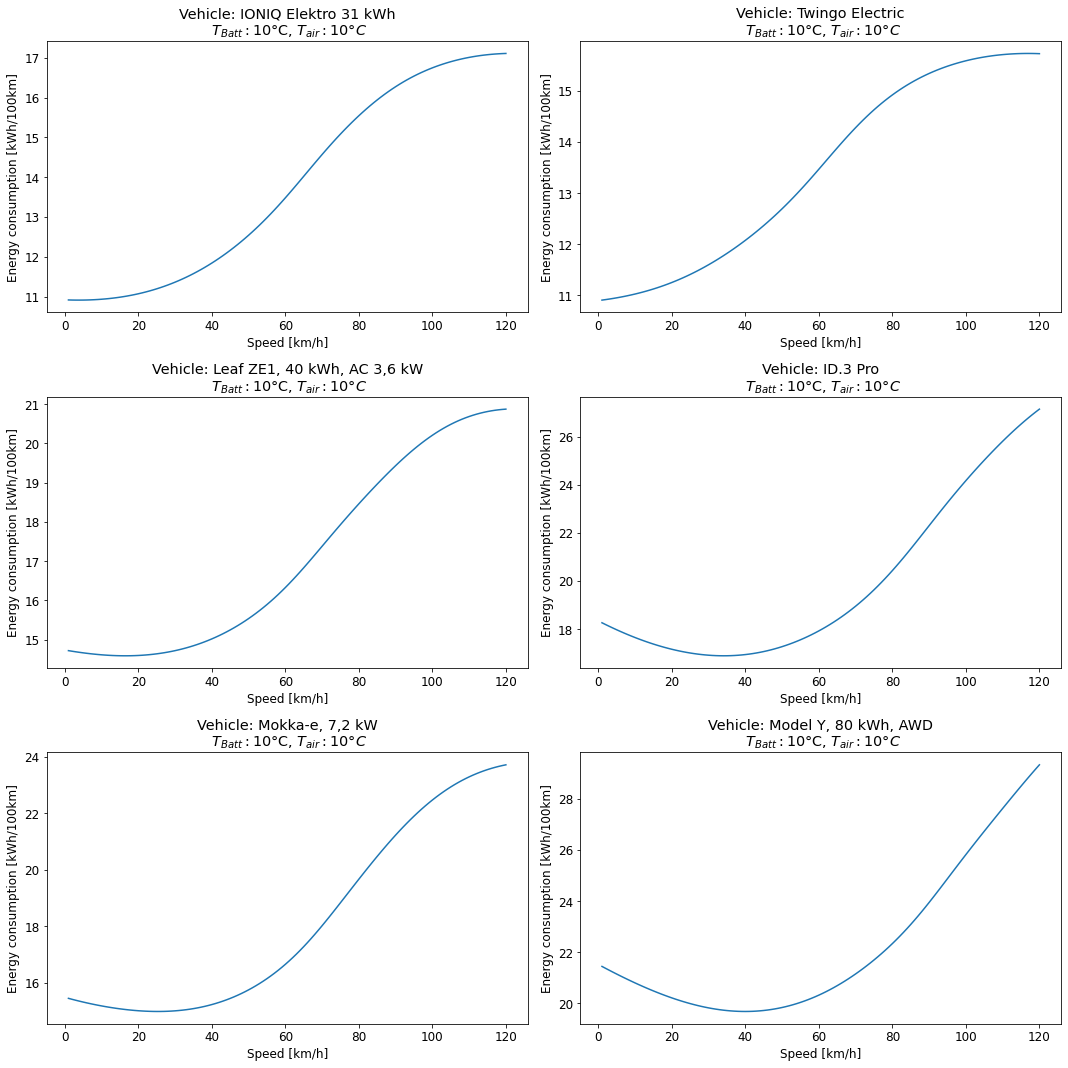

In [458]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15 ), tight_layout=True)
plt.rc('font', size=12);

vvids = [391,431,432,437,473,586]

for n, vvid in enumerate(vvids):
    t_b = 10
    t_a = 10
    soc = 100
    vehicle_name = vvid_dict[vvid]["name"]
    df = get_consumption_curve(mlp_hp_best, vvid, t_b, t_a, soc)
    
    ax = plt.subplot(3,2,n+1)
    ax.plot(df.speed_av, df.consumption)
    ax.set_ylabel("Energy consumption [kWh/100km]")
#     ax.plot(df.speed_av, df.drive_range)
    ax.set_xlabel("Speed [km/h]")
#     ax.set_ylabel("Drive Range [km]")
    ax.set_title(f"Vehicle: {vehicle_name}\n $T_{{Batt}}: {t_b}$°C, $T_{{air}}: {t_a}°C$")

The consumption curves above were calculated for the case where battery temperature and air temperature are both 10°C. 

Below we are depicted the range curves estimated from the consumption curves above.

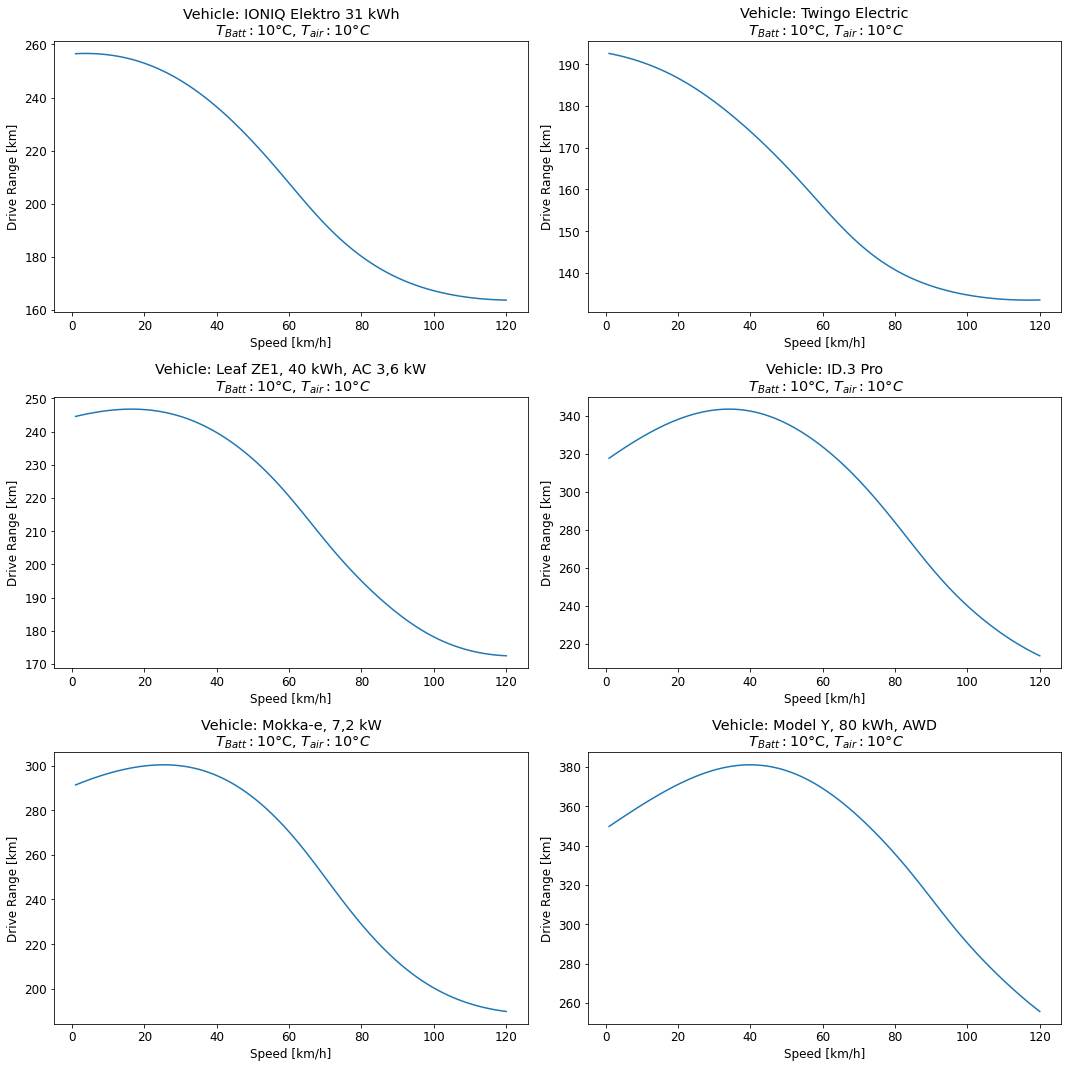

In [457]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15 ), tight_layout=True)
plt.rc('font', size=12);

for n, vvid in enumerate(vvids):
    vehicle_name = vvid_dict[vvid]["name"]
    df = get_consumption_curve(mlp_hp_best, vvid, t_b, t_a, soc)
    
    ax = plt.subplot(3,2,n+1)
    ax.plot(df.speed_av, df.drive_range)
    ax.set_xlabel("Speed [km/h]")
    ax.set_ylabel("Drive Range [km]")
    ax.set_title(f"Vehicle: {vehicle_name}\n $T_{{Batt}}: {t_b}$°C, $T_{{air}}: {t_a}°C$")

## Conclusions

In this report we have studied the possibility to develop a simplified machine learning model for the determination of EVs energy consumption. This simplified model is able to estimate the final energy consumption in terms of the battery SoC taking into consideration information of the initial conditions of a route such as the initial battery temperature, the air temperature, initial SoC, the altitude and altitude difference, total route distance and the average speed. The developed model achieved nice scoring statistics such a mean absolute error of 1.15 SoC% and a really good coefficient of regression of about 0.99. Moreover, with this model we are able to construct the vehicles consumption curve and drive range as a function of speed for various battery and air temperatures.

Moreover, in comparison to the model determined in our [previous notebook](https://eclever.atlassian.net/wiki/spaces/DEV/pages/2923528193/Modeling+of+energy+consumption+Opel+Mokka), this model is much more simple and precise, with the advantage that we use a single model for all the vehicle variants for which we have data.  

In terms of the applicability of this model, not only the routing algorithm will profit but also services in the back-end where, for instance, the determination of rest drive range is required.

## Appendix

1. Widget to plot consumption curves and drive range for EVs

In [454]:
from ipywidgets import interactive, fixed

vvids = sorted(X_test.vehiclevariant_id.unique())
interactive(
    plot_consumption_range, model=fixed(mlp_hp_best), vvid=vvids,
    t_b=(-10,40, 1), t_a=(-10,40, 1), soc=(10,100,1)
)

Widget Javascript not detected.  It may not be installed or enabled properly.


2. Hyperparameter tunning functions

In [225]:
import re
def plot_params_score(data):
    regex= "(?<=__)(\w+)"
    par_names = [par for par in data.params.iloc[0]]
    nr_params = int(len(par_names))
    if nr_params == 2:
        nr_rows, nr_cols = 1, 2
    elif nr_params == 1:
        nr_rows, nr_cols = 1, 1
    elif nr_params == 3:
        nr_rows, nr_cols = 2, 2
    elif nr_params%2 == 0:
        nr_rows = nr_cols = nr_params//2
    else:
        nr_rows, nr_cols = nr_params//2 + 1, nr_params//2
    fig = plt.figure(figsize=(10, 7))
    for i, par in enumerate(par_names):
        try:
            x =  pd.to_numeric(data["param_"+par])
        except:
            x = data["param_"+par].astype(str)
        ax = fig.add_subplot(nr_rows, nr_cols, i+1)
        ax.plot(x , data["mean_test_score"], "o")
        ax.set_xlabel(re.search(regex, par)[0])
        ax.set_ylabel("score")
    fig.tight_layout()



In [234]:
target_cols = [
    'soc_f'    
]

feature_cols = [
#     'timestamp',
    "altitude_i",
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    "odometer",
    'battery_temp_i',
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
    "vehiclevariant_id",
#    "consumptioncurve_id",
]


X_train, X_test, y_train, y_test = do_train_test_split(
        data_cleaned, feature_cols, target_cols, "vehiclevariant_id")

# Hyperparams optimization for mlpregressor
param_grid = {
    'mlpregressor__hidden_layer_sizes':range(100,1001, 100),
#     'mlpregressor__hidden_layer_sizes':[120],
#      'mlpregressor__max_iter': range(400, 1501, 100),
#     'mlpregressor__max_iter': [500],
    'mlpregressor__max_iter': range(200, 1501, 100),
#     'mlpregressor__beta_1': [0.9],
#     'mlpregressor__beta_2': [0.7],
    'mlpregressor__beta_1': np.linspace(0.1,0.9, 9),
    'mlpregressor__beta_2': np.linspace(0.1,0.9, 9),
    'mlpregressor__activation': ['relu','tanh', "logistic"],
#     'mlpregressor__activation': ["logistic"],
#     'mlpregressor__alpha': np.geomspace(1e-5,1,6),
#    'mlpregressor__learning_rate': ['constant','adaptive'],
}

# Create a based model
mlp_hp = setup_models_one_hot(cat_cols, scaler="standard_scaler")["MLPRegressor"]

# Instantiate the grid search model
mlp_grid_search = RandomizedSearchCV(estimator=mlp_hp,
                                     param_distributions=param_grid,
                                     cv=skf.split(X_train, X_train["vehiclevariant_id"]),
                                     n_iter=400,
                                     n_jobs=-1,
                                     random_state=42,
                                     verbose=True)

mlp_grid_search.fit(X_train, y_train.values.ravel());

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pa

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-p

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-p

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pac

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pac

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pac

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pa

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pa

{'mlpregressor__max_iter': 900, 'mlpregressor__hidden_layer_sizes': 400, 'mlpregressor__beta_2': 0.6, 'mlpregressor__beta_1': 0.5, 'mlpregressor__activation': 'logistic'} 0.9898783232804872
Table . MLP. metrics before and after fine tuning.


MAE   RMSE  $r^2$
Optimization                     
before        1.182  2.412  0.989
after         1.140  2.376  0.990

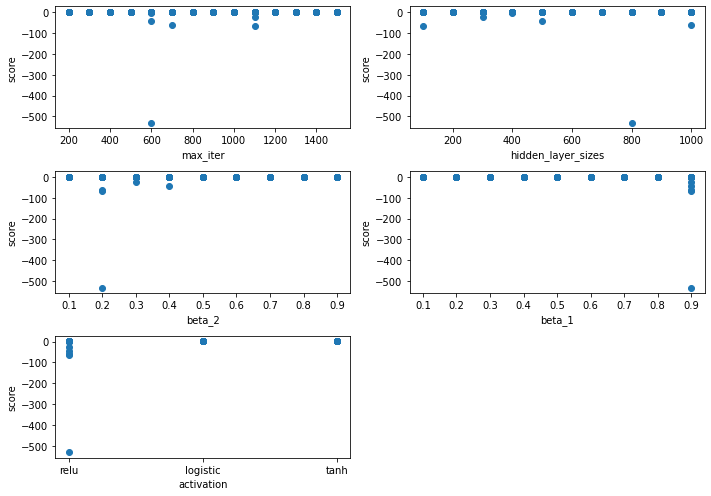

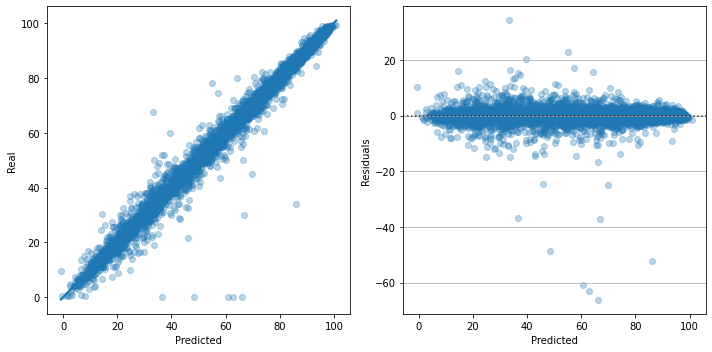

In [235]:
print(mlp_grid_search.best_params_, mlp_grid_search.best_score_)

mlp_hp_best = mlp_grid_search.best_estimator_

base_model = setup_models_one_hot(
    cat_cols, scaler="standard_scaler")["MLPRegressor"]
base_model.fit(X_train, y_train)

mlp_before = evaluate_model(base_model, X_test, y_test)
mlp_before["Optimization"] = "before"

mlp_after = evaluate_model(mlp_hp_best, X_test, y_test)
mlp_after["Optimization"] = "after"

grid_res = pd.DataFrame(mlp_grid_search.cv_results_)
plot_params_score(grid_res)

plt.rc('font', size=10)
plot_residuals(mlp_hp_best, X_test, y_test.values.reshape(-1), hue=None);

print("Table . MLP. metrics before and after fine tuning.")
pd.concat([mlp_before, mlp_after]).set_index("Optimization")

(1.788628512411493, 100)

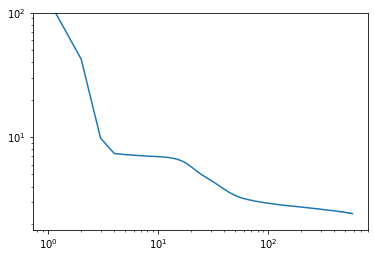

In [238]:
plt.plot(mlp_hp_best[1].loss_curve_)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0,100)


In [227]:
def get_nr_layers(ni, no, ns, a=5):
    """
    Estimates the upper bound of the number of neurons to use in a hidden layer
    
    Parameters:
        ni : Number of input neurones (features)
        no : Number of output neurones (target)
        ns: Number of training sample
        a : scaling factor, between 2 and 10
    """
    return round(ns / (a * (ni +no)))

In [247]:
get_nr_layers(mlp_hp_best[1].n_features_in_, 1, len(y_train))

204

3. Model without altitude_i

In [459]:
warnings.filterwarnings("ignore", message="ConvergenceWarning")
# initial data
target_cols = [
    'soc_f'    
]

feature_cols = [
#     'timestamp',
#     "altitude_i",
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
    "vehiclevariant_id",
#    "consumptioncurve_id",
]
selector_res_vvid = model_selector1(
    data_cleaned, feature_cols, target_cols, cat_cols, "vehiclevariant_id")

text = "Table 2. Algorithm scores - Vehicle variant ID"
print(text, "\n"+"_"*len(text))
selector_res_vvid.sort_values(by="RMSE").head(10)

Table 2. Algorithm scores - Vehicle variant ID 
______________________________________________


cv_score              scaler    MAE   RMSE  $r^2$
model                                                                       
MLPRegressor               2.415988     standard_scaler  1.190  2.437  0.989
MLPRegressor               2.457641        power_scaler  1.196  2.447  0.989
MLPRegressor               2.530217                None  1.228  2.499  0.988
MLPRegressor               2.551862  quantile_transform  1.240  2.506  0.988
ExtraTreesRegressor        2.891539                None  1.417  2.829  0.985
RandomForestRegressor      3.179151                None  1.581  3.044  0.983
SVR                        3.472319     standard_scaler  1.478  3.204  0.981
GradientBoostingRegressor  3.272614                None  1.731  3.238  0.981
SVR                        3.623948  quantile_transform  1.559  3.329  0.979
ARDRegression              3.655133                None  2.073  3.635  0.975

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize

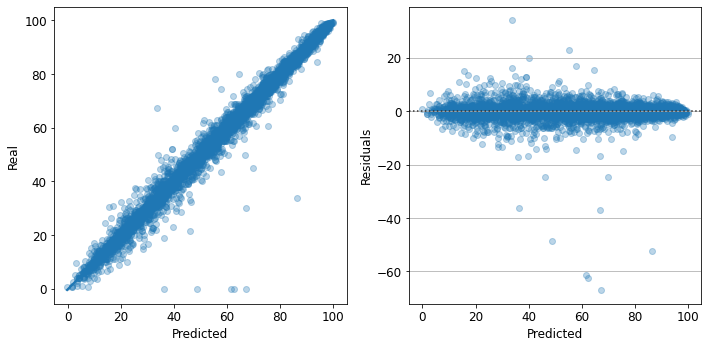

In [461]:
mlp_hp_test = setup_models_one_hot(cat_cols, scaler="standard_scaler")["MLPRegressor"]
mlp_hp_test.fit(X_train[feature_cols], y_train)
plot_residuals(mlp_hp_best, X_test, y_test.values.reshape(-1), hue=None);

In [462]:
mlp_hp_test[0]._feature_names_in

array(['delta_altitude', 'speed_av', 'total_distance', 'air_temp',
       'soc_i', 'battery_temp_i', 'vehiclevariant_id'], dtype=object)

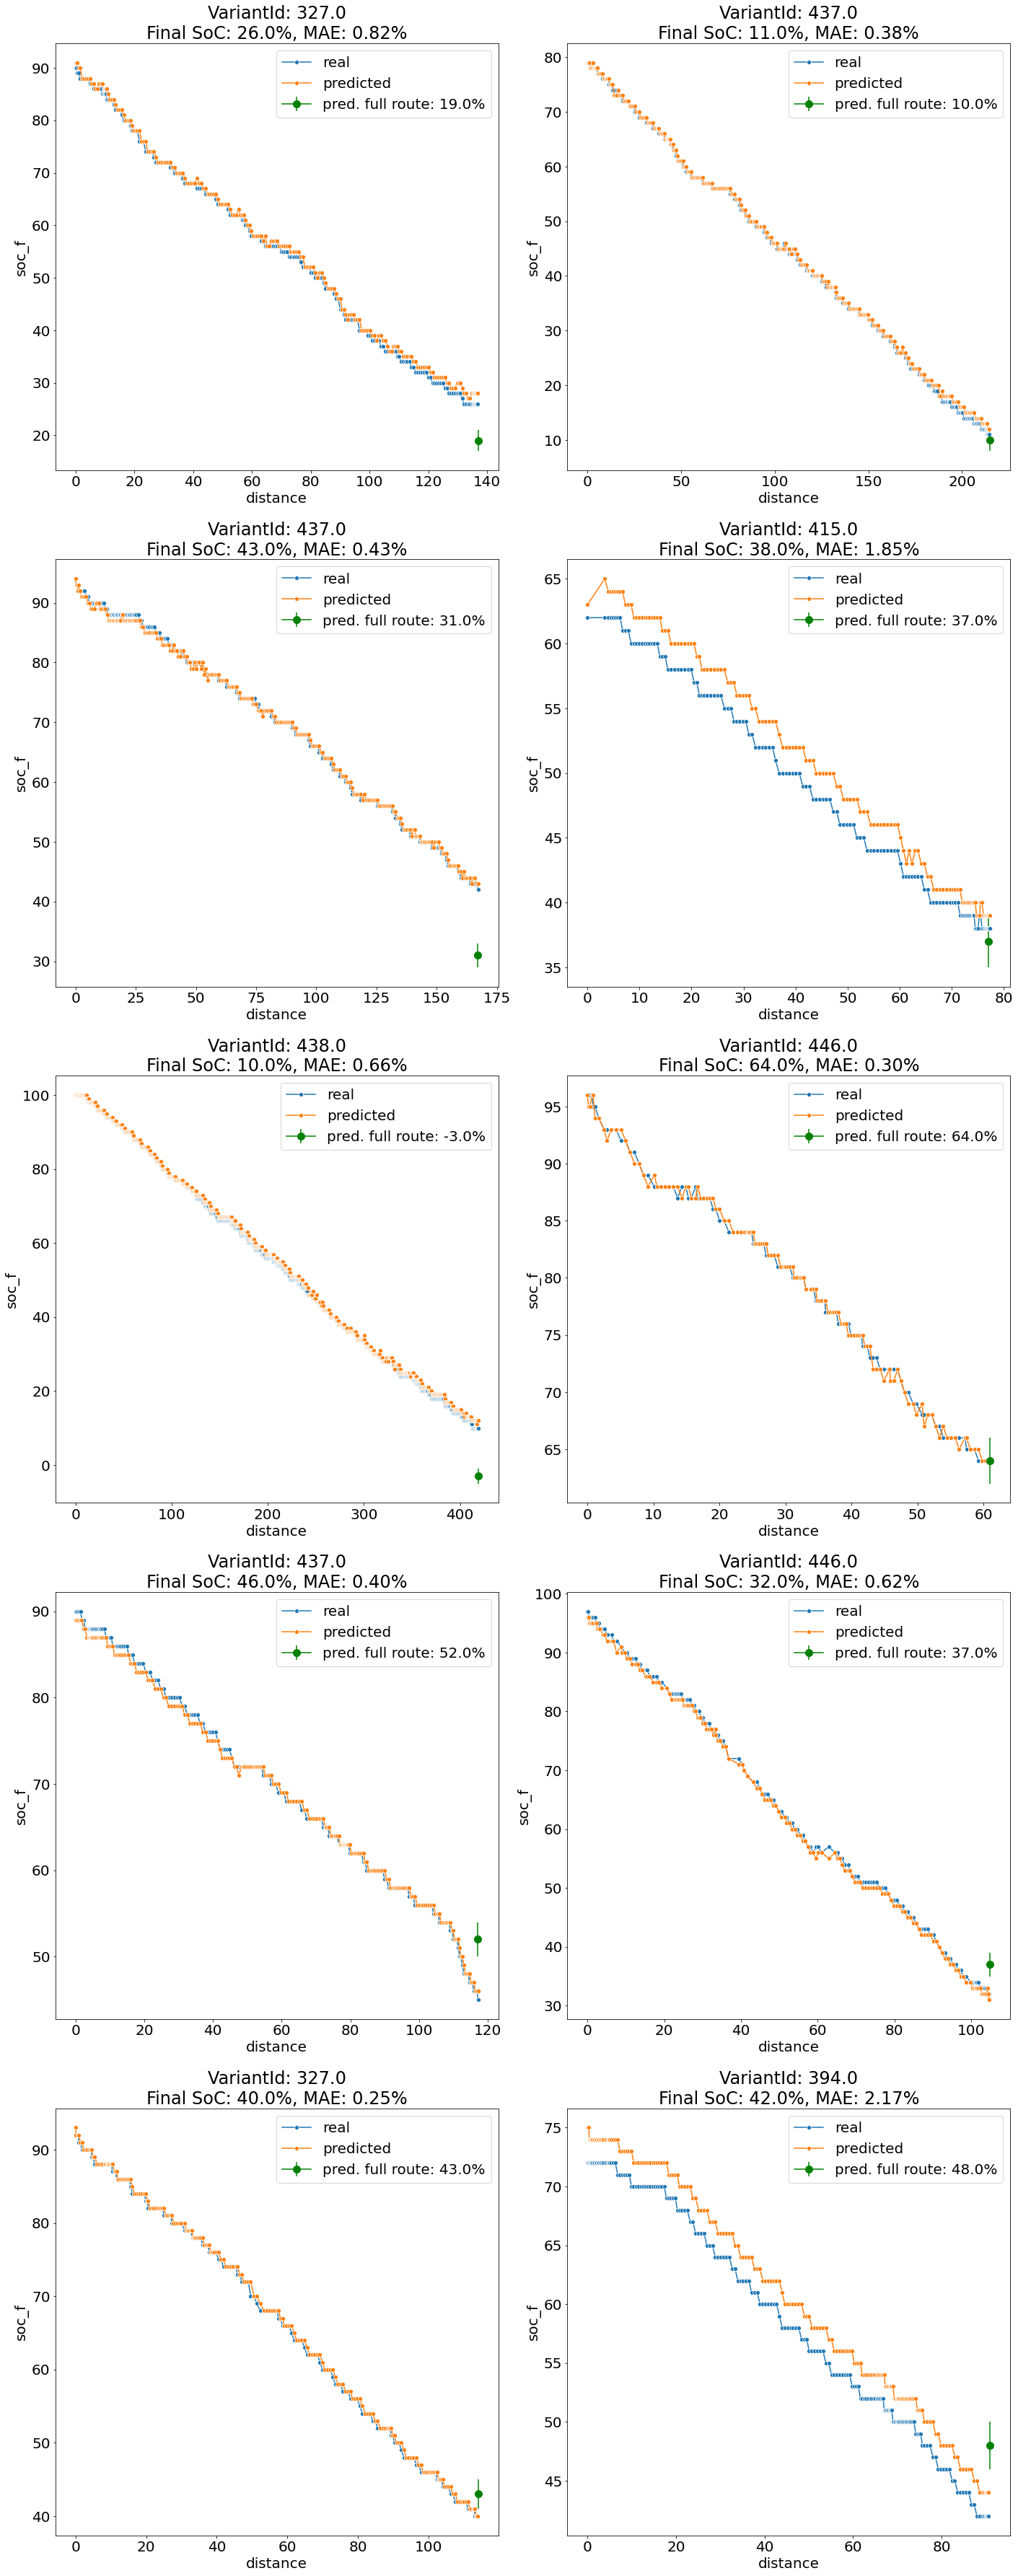

In [464]:
def plot_check_with_real(drive, ax, model):
    test_df = pd.DataFrame({
        'altitude':drive.altitude,
        'speed':drive.speed,
        'distance': drive.distance,
        'air_temp':drive.air_temp.round(),
        'soc':drive.soc.round(),
        'time':drive.time,
        'battery_temp':drive.battery_temp.round(),
        "vehiclevariant_id": drive.vehiclevariant_id,
    })
    # ML features for each point in drive
    test_df['altitude_i'] = test_df.altitude
    test_df['delta_altitude'] = test_df.altitude.diff().shift(-1)
    test_df['speed_av'] = round(test_df.distance.iloc[-1] / test_df.time.iloc[0])
    test_df['total_distance']=test_df.distance.diff().shift(-1)
    test_df['air_temp'] = test_df.air_temp
    test_df['soc_i'] = test_df.soc
    test_df['soc_f'] = test_df.soc.shift(-1)
    test_df['battery_temp_i'] = test_df.battery_temp
    test_df = test_df.dropna()
    test_df["predicted"] = model.predict(test_df[feature_cols]).round()

    # ML features for the whole drive
    full_trip = pd.DataFrame({
        "altitude_i": test_df.altitude.iloc[0],
        'delta_altitude': test_df.altitude.iloc[-1] - test_df.altitude.iloc[0],
        "speed_av": round(test_df.distance.iloc[-1] / (test_df.time.iloc[-1])),
        "total_distance": test_df.distance.iloc[-1].round(),
        "air_temp": test_df.air_temp.iloc[0],
        "soc_i": test_df.soc.iloc[0],
        "battery_temp_i": test_df.battery_temp.iloc[0],
        "vehiclevariant_id": test_df.vehiclevariant_id.iloc[0]
    }, index=[0])

    full_trip["predicted"] = model.predict(full_trip[feature_cols]).round()
    
    sns.lineplot(data=test_df, x="distance", y="soc_f",  marker='o', label="real", ax=ax);
    sns.lineplot(data=test_df, x="distance", y="predicted",  marker='o', label="predicted", ax=ax);
    ax.errorbar(full_trip.total_distance, full_trip.predicted, yerr=2, marker="o", ms=10, c="green", label=f"pred. full route: {full_trip.predicted[0]}%");
    ax.set_title("VariantId: {}\nFinal SoC: {}%, MAE: {:.2f}%".format(
        test_df.vehiclevariant_id.iloc[0],
        test_df.soc.iloc[-1],
        mean_absolute_error(test_df.predicted, test_df.soc_f)));
    
fig = plt.figure(figsize=(20,50));
plt.rc('font', size=20);
for i, drive in enumerate(drives):
    ax = fig.add_subplot(5,2,i+1);
    plot_check_with_real(drive, ax, mlp_hp_test);
    ax.legend()
    plt.tight_layout();